# PPU mix optimization for energy sovereignty

Abstract: Identify the combinations of PPU that balance price minimization, minimization of external dependencies and maximizes renewable energy.  

## Part 1 - Import of data

We import to begin the following descriptions (01.01.2024 to 31.12.2024): 
- Electrical energy spot price 
- Wind repartition 
- Solar incidence
- Exchange rates

### Dependencies

We begin by importing all the necessary libraries

In [22]:
import pandas as pd
import numpy as np
import networkx as nx

import gurobipy as gp
from gurobipy import GRB

import re
import warnings
warnings.filterwarnings("ignore")

# Exterior folders 

from data_visualization import plot_spot_price, analyze_spot_price, analyze_solar_incidence, plot_monthly_solar_apport, analyze_wind_incidence, plot_monthly_wind_apport, analyze_monthly_hourly_load, analyze_exchange_values, visualize_ror_monthly, visualize_storage_monthly


### Data scrapping

We have the following ressources: 
- spot electricity price : https://api.energy-charts.info/?
- solar incidence : https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview
- wind incidence : https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=download
- exchange rate (CHF/EUR) : https://www.exchange-rates.org/exchange-rate-history/chf-eur-2024
- energy consumption in Switzerland (): https://www.entsoe.eu/data/power-stats/
- water RoR (run of river) $\mathrm{m^3}$ per month : https://transparency.entsoe.eu/
- Water storage ($\mathrm{m^3}$) per month : https://www.bfe.admin.ch/bfe/de/home/versorgung/statistik-und-geodaten/
- Water storage total available is $3.5\,\mathrm{km^3}$: https://ethz.ch/content/dam/ethz/special-interest/baug/department/news/dokumente/Hydropower_Synthesis_Report_sm.pdf



### 1 - Spot electricity price 2024

import spot price of electricity derived of the EPEX SPOT price (EUR/MWh). 

In [23]:
# Extract values from spot price JSON and put them in a DataFrame
import json
import pandas as pd
from pathlib import Path

# Load spot price JSON
data_path = Path("data/energy_price_all_2024.json")
with open(data_path, "r") as f:
    spot_data = json.load(f)

# Extract values and create DataFrame
# Assumes spot_data has keys 'unix_seconds' and 'price'
spot_df = pd.DataFrame({
    'time': pd.to_datetime(spot_data['unix_seconds'], unit='s', utc=True),
    'price': spot_data['price']
})
spot_df.set_index('time', inplace=True)

print(spot_df.head())


                           price
time                            
2023-12-31 23:00:00+00:00  25.97
2024-01-01 00:00:00+00:00  21.99
2024-01-01 01:00:00+00:00  14.32
2024-01-01 02:00:00+00:00  11.37
2024-01-01 03:00:00+00:00  11.35


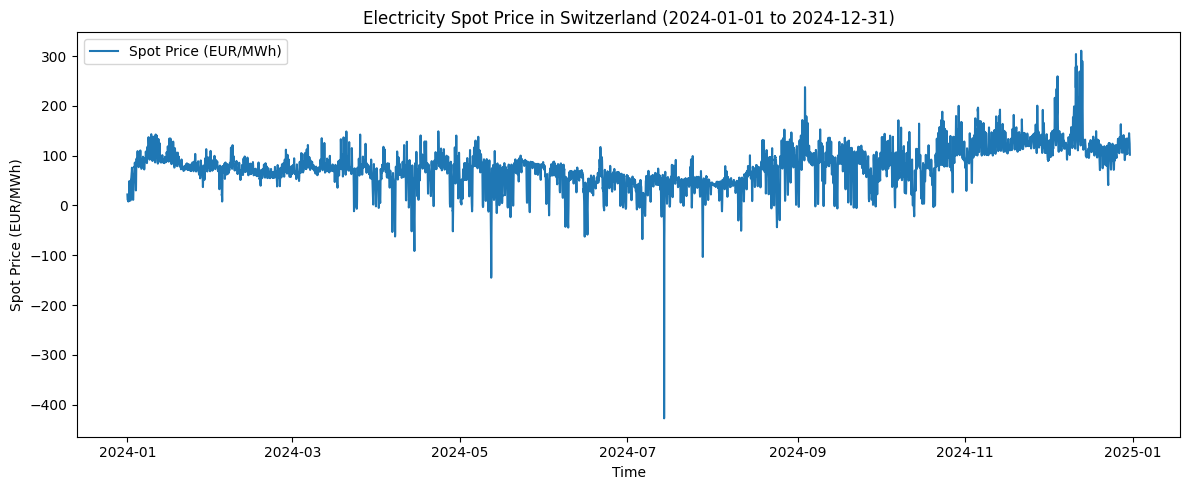

In [24]:
plot_spot_price(
    csv_path = "data/spot_price_hourly.csv",
    start_date = "2024-01-01",
    end_date = "2024-12-31"
    )

Spot Price Statistics (2024-01-01 to 2024-12-31):
  Mean: 75.8649
  Median: 75.7500
  Mode: 78.9400
  Std: 38.9859
  Skewness (3rd moment): -0.1299
  Kurtosis (4th moment): 5.3287


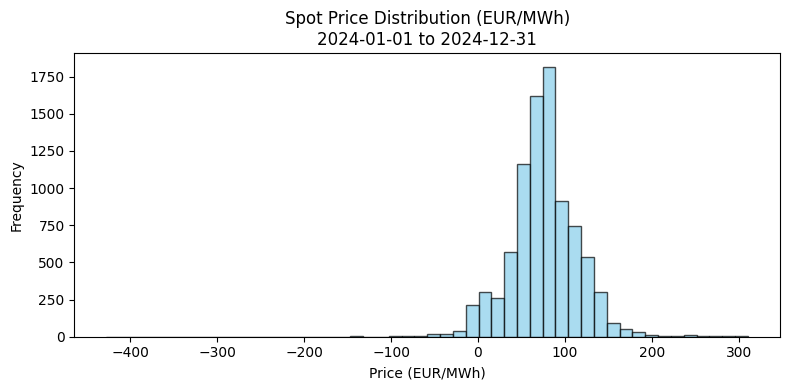

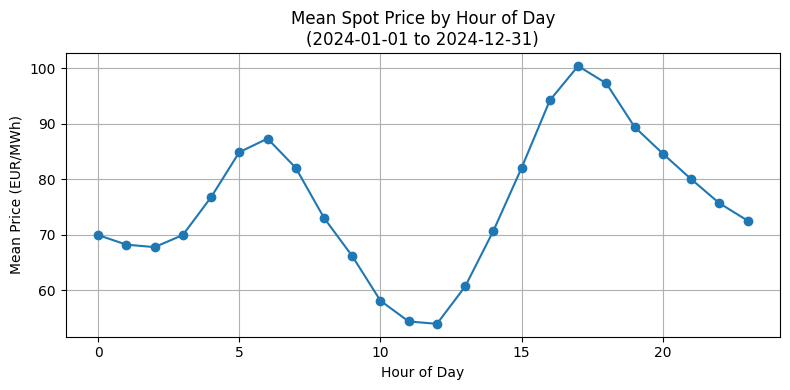

In [25]:
analyze_spot_price( csv_path="data/spot_price_hourly.csv",
    start_date="2024-01-01", 
    end_date="2024-12-31")

### 2 -Solar incidence

import solar incidence data and generate csv. Should only be needed once. Gives the solar incidence (kWh/m^2) per location for 2024:

In [26]:
# Analysis: Aggregate hourly solar incidence for each location over 2024 (skip .idx files, fixed time index)
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd

solar_dir = Path("data/solar_incidence")
# Only include files that do NOT end with .idx
valid_grib_files = sorted([p for p in solar_dir.rglob("*") if p.is_file() and not p.name.endswith('.idx')])

all_dsets = []
for f in valid_grib_files:
    try:
        ds = xr.open_dataset(
            f,
            engine="cfgrib",
            backend_kwargs={"filter_by_keys": {"shortName": "ssrd"}},
        )
        all_dsets.append(ds)
    except Exception as e:
        print(f"Failed to open {f}: {e}")

if not all_dsets:
    raise RuntimeError("No GRIB datasets could be opened.")

ds_all = xr.combine_by_coords(all_dsets, combine_attrs="override")

var_name = next((v for v in ds_all.data_vars if v.lower() in ("ssrd", "surface_solar_radiation_downwards")), None)
if var_name is None:
    var_name = next((v for v in ds_all.data_vars if "ssrd" in v.lower()), None)
if var_name is None:
    raise KeyError(f"No SSRD-like variable found. Variables: {list(ds_all.data_vars)}")

units_attr = str(ds_all[var_name].attrs.get("units", "")).lower()
if ("j" in units_attr) and ("/m" in units_attr):
    ghi_kwh = ds_all[var_name] / 3_600_000.0  # J/m^2 per hour -> kWh/m^2 per hour
else:
    ghi_kwh = ds_all[var_name]

# Do NOT reset_index; keep time as index
df = ghi_kwh.to_dataframe()  # time is index

df_pivot = df.pivot_table(index="time", columns=["latitude", "longitude"], values=var_name)
df_pivot.index.name = "time"  # Ensure the index is named

print("Hourly solar incidence (kWh/m^2) per location for 2024:")
df_pivot.head()

Hourly solar incidence (kWh/m^2) per location for 2024:


latitude          45.7                                                   \
longitude         5.8         5.9         6.0         6.1          6.2    
time                                                                      
2023-12-31  2066512.00  2128952.00  2200396.00  2295184.00  2371076.000   
2024-01-01  2672944.75  2678032.75  2710860.75  2786953.00  2886692.000   
2024-01-02  1008955.25  1017062.75  1040888.75  1084788.50  1134089.375   
2024-01-03  2411268.00  2395203.75  2389994.75  2404703.00  2404683.000   
2024-01-04  2868536.75  2851082.75  2839008.75  2830539.75  2811066.750   

latitude                                                                   \
longitude          6.3         6.4          6.5          6.6         6.7    
time                                                                        
2023-12-31  2449508.000  2577300.00  2871608.000  3166292.000  3428856.00   
2024-01-01  2985971.000  3077175.00  3141130.750  3205210.750  3266338.00   
2024-01-02  1184724.125  1260928.25  1423597.625  1585890.875  1753001.00   
2024-01-03  2407051.750  2455293.25  2658326.000  2861217.750  3050226.25   
2024-01-04  2793489.000  2815114.75  2968799.250  3122322.000  3265960.75   

latitude    ...        47.9                                            \
longitude   ...        9.8           9.9           10.0          10.1   
time        ...                                                         
2023-12-31  ...  3754640.00  3.761048e+06  3.767124e+06  3.755960e+06   
2024-01-01  ...  2461277.25  2.492385e+06  2.523598e+06  2.561136e+06   
2024-01-02  ...   862397.75  8.933696e+05  9.243109e+05  9.545262e+05   
2024-01-03  ...  2181577.00  2.239140e+06  2.296673e+06  2.356289e+06   
2024-01-04  ...  2203260.50  2.219899e+06  2.236535e+06  2.254671e+06   

latitude                                                                       \
longitude           10.2          10.3        10.4         10.5          10.6   
time                                                                            
2023-12-31  3.744464e+06  3.732836e+06  3723876.00  3722348.000  3.729952e+06   
2024-01-01  2.598781e+06  2.636367e+06  2670231.00  2698960.750  2.723382e+06   
2024-01-02  9.847148e+05  1.015307e+06  1039718.00  1048976.125  1.043128e+06   
2024-01-03  2.415841e+06  2.474906e+06  2522837.25  2557684.250  2.584773e+06   
2024-01-04  2.272854e+06  2.291158e+06  2314225.50  2343869.000  2.378501e+06   

latitude                  
longitude           10.7  
time                      
2023-12-31  3.737376e+06  
2024-01-01  2.747827e+06  
2024-01-02  1.037193e+06  
2024-01-03  2.611845e+06  
2024-01-04  2.413072e+06  

[5 rows x 1150 columns]

In [27]:
# Export the concatenated solar incidence DataFrame to CSV
output_csv = "data/solar_incidence_hourly_2024.csv"
df_pivot.to_csv(output_csv)
print(f"Saved all solar incidence data to {output_csv}")

Saved all solar incidence data to data/solar_incidence_hourly_2024.csv


Solar Incidence Statistics (2024-01-01 to 2024-12-31):
  Mean: 6833044.9366 kWh/m^2
  Median: 5919581.0000 kWh/m^2
  Mode: 9555113.0000 kWh/m^2
  Std: 3929886.7182 kWh/m^2
  Skewness: 0.3574
  Kurtosis: -1.1005


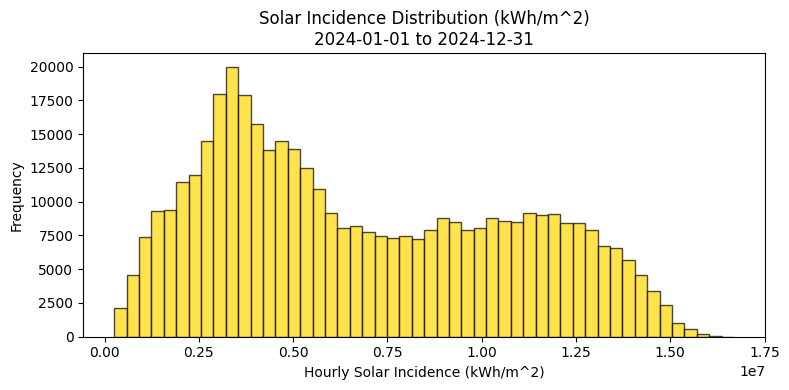

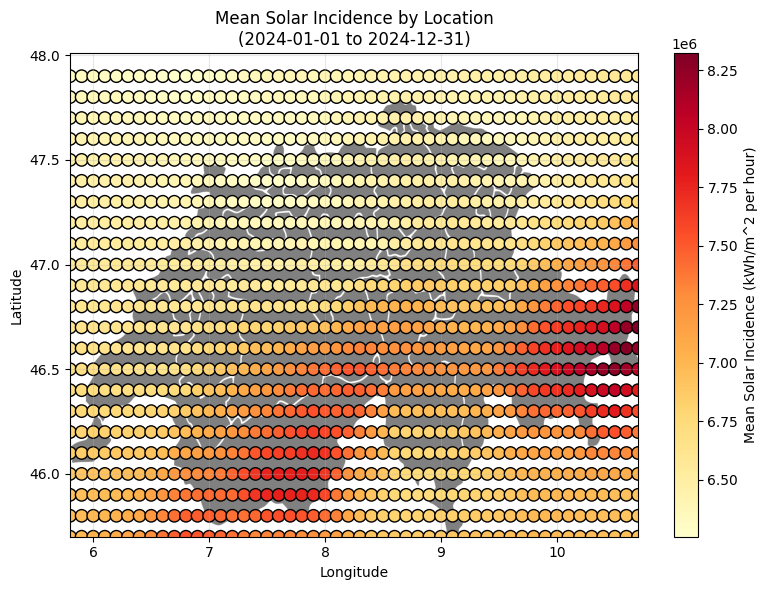

In [28]:
analyze_solar_incidence(
    "data/solar_incidence_hourly_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31",
    background_img_path="data/Switzerland.png"
)

#### Ranking ideal positions

Ranking ideal positions to install PV

In [29]:
import os
import pandas as pd
import numpy as np
import csv

# Create ranking_incidence folder if not exists
os.makedirs("data/ranking_incidence", exist_ok=True)

# Load solar incidence CSV
csv_path = "data/solar_incidence_hourly_2024.csv"

# Read the header rows to get lat/lon
with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    lat_row = next(reader)
    lon_row = next(reader)
    # Skip time_row
    next(reader)

# Read the data, skipping first 3 rows
df = pd.read_csv(csv_path, skiprows=3)
df.rename(columns={df.columns[0]: "time"}, inplace=True)
df["time"] = pd.to_datetime(df["time"])

# Data columns (each is a location)
data_cols = [col for col in df.columns if col != "time"]

# Compute mean solar incidence per location
mean_by_loc = df[data_cols].mean()

# Extract lat/lon for each location (skip first element if it's empty)
lats = [float(x) for x in lat_row[1:]]
lons = [float(x) for x in lon_row[1:]]

# Create DataFrame
ranking_df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'mean_solar_incidence_kwh_m2_per_hour': mean_by_loc.values
})

# Sort by mean descending (highest incidence first)
ranking_df = ranking_df.sort_values('mean_solar_incidence_kwh_m2_per_hour', ascending=False).reset_index(drop=True)

# Add rank column
ranking_df['rank'] = ranking_df.index + 1

# Save to CSV
output_csv = "data/ranking_incidence/solar_incidence_ranking.csv"
ranking_df.to_csv(output_csv, index=False)

print(f"Saved solar incidence ranking to {output_csv}")
print("Top 10 locations:")
print(ranking_df.head(10))

Saved solar incidence ranking to data/ranking_incidence/solar_incidence_ranking.csv
Top 10 locations:
   latitude  longitude  mean_solar_incidence_kwh_m2_per_hour  rank
0      46.7       10.7                          8.322604e+06     1
1      46.6       10.6                          8.296430e+06     2
2      46.5       10.5                          8.251820e+06     3
3      46.5       10.4                          8.231555e+06     4
4      46.8       10.7                          8.229062e+06     5
5      46.7       10.6                          8.223767e+06     6
6      46.6       10.5                          8.221273e+06     7
7      46.6       10.7                          8.217838e+06     8
8      46.5       10.6                          8.182618e+06     9
9      46.5       10.3                          8.139429e+06    10


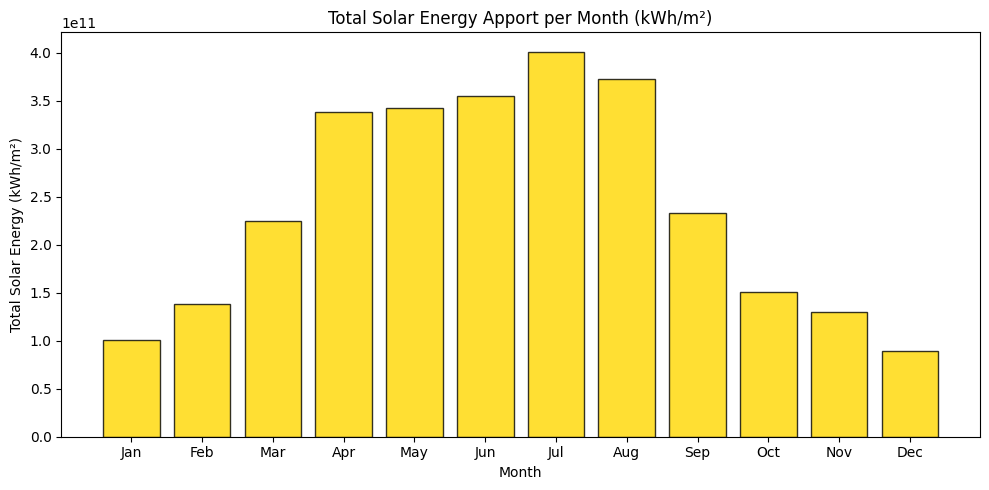

In [30]:
plot_monthly_solar_apport(
    "data/solar_incidence_hourly_2024.csv", 
    start_date="2024-01-01", 
    end_date="2024-12-31"
    )

### 3 - Wind incidence 

Wind incidence is given by 10m u-component of wind, 10m v-component of wind in (m/s).

In [31]:
# List and open one file from data/wind_incidence to inspect its contents
from pathlib import Path
import xarray as xr

wind_dir = Path("data/wind_incidence")
# List all files (excluding .idx)
wind_files = sorted([p for p in wind_dir.rglob("*") if p.is_file() and not p.name.endswith('.idx')])
print(f"Found {len(wind_files)} files. First file: {wind_files[0] if wind_files else 'None'}")

# Open the first file and print its structure
if wind_files:
    ds = xr.open_dataset(wind_files[0], engine="cfgrib")
    print(ds)
    print("Variables:", list(ds.data_vars))
    print("Attributes:", ds.attrs)
else:
    print("No wind incidence files found.")

Found 12 files. First file: data/wind_incidence/apr2024_wind.grib
<xarray.Dataset> Size: 7MB
Dimensions:     (time: 31, step: 24, latitude: 23, longitude: 50)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 248B 2024-03-31 2024-04-01 ... 2024-04-30
  * step        (step) timedelta64[ns] 192B 01:00:00 ... 1 days 00:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 184B 47.9 47.8 47.7 47.6 ... 45.9 45.8 45.7
  * longitude   (longitude) float64 400B 5.8 5.9 6.0 6.1 ... 10.4 10.5 10.6 10.7
    valid_time  (time, step) datetime64[ns] 6kB ...
Data variables:
    u10         (time, step, latitude, longitude) float32 3MB ...
    v10         (time, step, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Eu

In [32]:
# Concatenate all wind incidence files into a single DataFrame (hourly wind speed) for the full year
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd

wind_dir = Path("data/wind_incidence")
wind_files = sorted([p for p in wind_dir.rglob("*") if p.is_file() and not p.name.endswith('.idx')])

print("Wind files found:")
for wf in wind_files:
    print("  ", wf)

all_dfs = []
opened_files = []
for f in wind_files:
    try:
        ds = xr.open_dataset(f, engine="cfgrib")
        wind_speed = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
        # If 'valid_time' exists, use it as the time coordinate
        if "valid_time" in ds:
            wind_speed = wind_speed.assign_coords(time=ds["valid_time"])
        df = wind_speed.to_dataframe(name="wind_speed").reset_index()
        all_dfs.append(df)
        opened_files.append(str(f))
    except Exception as e:
        print(f"Failed to open {f}: {e}")

print("Successfully opened files:")
for of in opened_files:
    print("  ", of)

if not all_dfs:
    raise RuntimeError("No valid wind incidence dataframes could be loaded.")

# Concatenate all months
wind_data_df = pd.concat(all_dfs, ignore_index=True)
print(wind_data_df.head())
print("Shape:", wind_data_df.shape)

# Use 'valid_time' as the datetime index for pivoting
wind_data_df = wind_data_df.rename(columns={"valid_time": "datetime"})
wind_data_df = wind_data_df.dropna(subset=["wind_speed", "datetime"])
wind_pivot = wind_data_df.pivot_table(index="datetime", columns=["latitude", "longitude"], values="wind_speed")
wind_pivot.index.name = "datetime"
print(wind_pivot.head())

# Save to CSV
wind_pivot.to_csv("data/wind_incidence_hourly_2024.csv")
print("Saved all wind incidence data to data/wind_incidence_hourly_2024.csv")

Wind files found:
   data/wind_incidence/apr2024_wind.grib
   data/wind_incidence/aug2024_wind.grib
   data/wind_incidence/dec2024_wind.grib
   data/wind_incidence/feb2024_wind.grib
   data/wind_incidence/jan2024_wind.grib
   data/wind_incidence/july2024_wind.grib
   data/wind_incidence/jun2024_wind.grib
   data/wind_incidence/mar2024_wind.grib
   data/wind_incidence/may2024_wind.grib
   data/wind_incidence/nov2024_wind.grib
   data/wind_incidence/oct2024_wind.grib
   data/wind_incidence/sept2024_wind.grib
Successfully opened files:
   data/wind_incidence/apr2024_wind.grib
   data/wind_incidence/aug2024_wind.grib
   data/wind_incidence/dec2024_wind.grib
   data/wind_incidence/feb2024_wind.grib
   data/wind_incidence/jan2024_wind.grib
   data/wind_incidence/july2024_wind.grib
   data/wind_incidence/jun2024_wind.grib
   data/wind_incidence/mar2024_wind.grib
   data/wind_incidence/may2024_wind.grib
   data/wind_incidence/nov2024_wind.grib
   data/wind_incidence/oct2024_wind.grib
   data/w

Wind Speed Statistics (2024-01-01 to 2024-12-31):
  Mean: 1.3393 m/s
  Median: 1.1305 m/s
  Mode: 1.0440 m/s
  Std: 0.9368 m/s
  Skewness: 1.9479
  Kurtosis: 5.6951


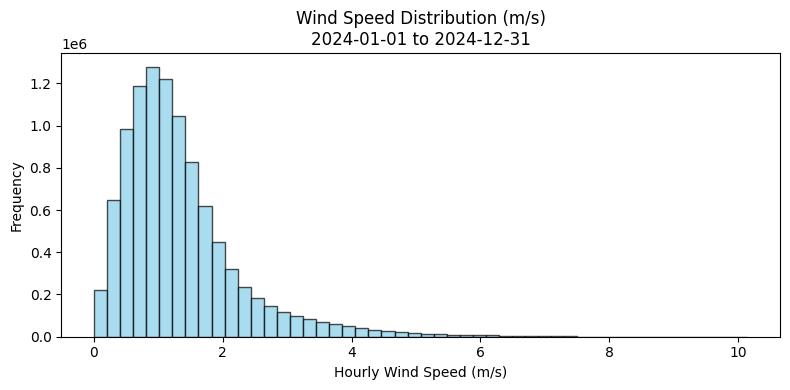

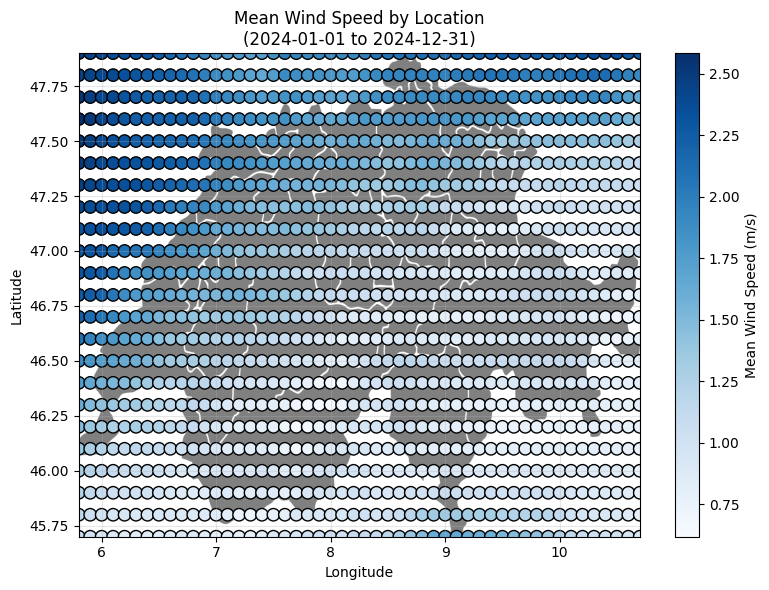

In [33]:
analyze_wind_incidence(
    "data/wind_incidence_hourly_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31",
    background_img_path="data/Switzerland.png"
)

#### Ranking ideal positions

Ranking ideal positions to install wind turbines

In [34]:
import os
import pandas as pd
import numpy as np

# Create ranking_incidence folder if not exists (already created by solar)
os.makedirs("data/ranking_incidence", exist_ok=True)

# Load wind incidence CSV
csv_path = "data/wind_incidence_hourly_2024.csv"

# Read the data with MultiIndex columns
df = pd.read_csv(csv_path, index_col=0, header=[0,1], parse_dates=True)

# Data columns (each is a location tuple (lat, lon))
data_cols = df.columns

# Compute mean wind speed per location
mean_by_loc = df[data_cols].mean()

# Extract lat/lon for each location
lats = [col[0] for col in data_cols]
lons = [col[1] for col in data_cols]

# Create DataFrame
ranking_df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'mean_wind_speed_m_per_s': mean_by_loc.values
})

# Sort by mean descending (highest wind speed first)
ranking_df = ranking_df.sort_values('mean_wind_speed_m_per_s', ascending=False).reset_index(drop=True)

# Add rank column
ranking_df['rank'] = ranking_df.index + 1

# Save to CSV
output_csv = "data/ranking_incidence/wind_incidence_ranking.csv"
ranking_df.to_csv(output_csv, index=False)

print(f"Saved wind incidence ranking to {output_csv}")
print("Top 10 locations:")
print(ranking_df.head(10))

Saved wind incidence ranking to data/ranking_incidence/wind_incidence_ranking.csv
Top 10 locations:
             latitude           longitude  mean_wind_speed_m_per_s  rank
0  47.599999999999994                 5.8                 2.580371     1
1   47.49999999999999                 5.8                 2.534964     2
2  47.699999999999996                 5.8                 2.533673     3
3   47.39999999999999                 5.8                 2.508964     4
4  47.599999999999994  5.8999999999999995                 2.504037     5
5  47.699999999999996  5.8999999999999995                 2.466343     6
6                47.9                 5.8                 2.465996     7
7                47.8                 5.8                 2.465354     8
8   47.29999999999999                 5.8                 2.463216     9
9   47.49999999999999  5.8999999999999995                 2.461883    10


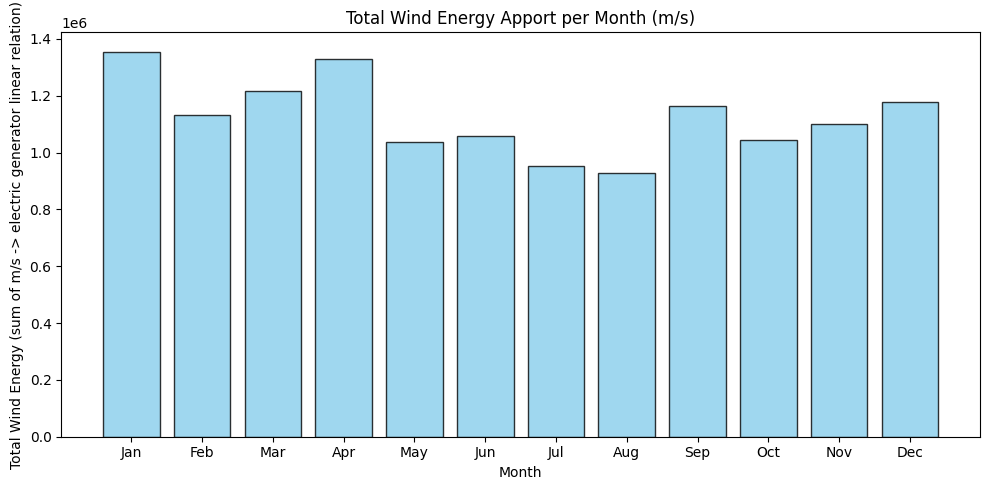

In [35]:
plot_monthly_wind_apport(
    "data/wind_incidence_hourly_2024.csv", 
    start_date="2024-01-01", 
    end_date="2024-12-31"
    )

### 4 - Exchange values

Exchange values to transform Eur/MWh in CHF/MWh.

In [36]:
# Inspect the head of the CHF to EUR exchange rate CSV
exchange_csv = "data/chf_to_eur_2024.csv"
df_exchange = pd.read_csv(exchange_csv)
df_exchange.head()

,Date,CHF to EUR
0,2024-01-01,1.0761
1,2024-01-02,1.0750
2,2024-01-03,1.0782
3,2024-01-04,1.0744
4,2024-01-05,1.0743


Exchange value statistics (Date):
count    262.000000
mean       1.050010
std        0.019376
min        1.006800
1%         1.009405
25%        1.031975
50%        1.055550
75%        1.066400
99%        1.077151
max        1.078200
Name: CHF to EUR, dtype: float64
  Min: 1.0068
  Max: 1.0782
  Mean: 1.0500
  Std: 0.0194


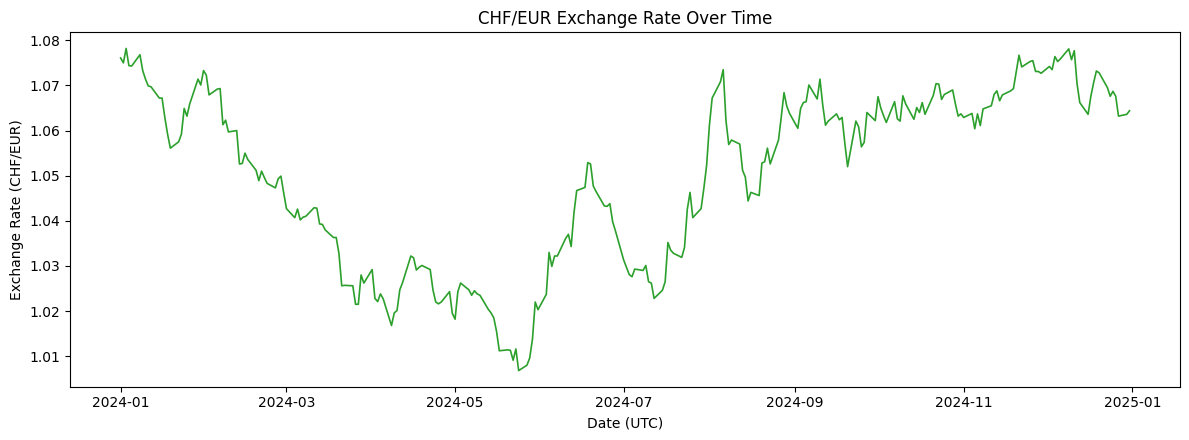

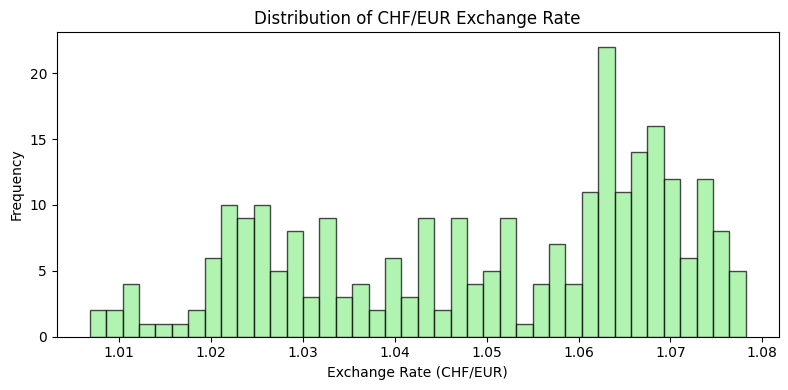

In [37]:
analyze_exchange_values("data/chf_to_eur_2024.csv")

### 5 - Hourly consumption rate

Hourly consumption rate of energy in Switzerland. Csv was ready for usage. 

Data from 2024-01-01 00:00:00 to 2024-12-31 00:00:00 (313133 hours)
Statistics:
count    313133.000000
mean       8854.783740
std       12853.608517
min           0.000000
1%          261.763200
25%        1090.570000
50%        4300.000000
75%        9427.500000
99%       60521.655100
max       82800.000000
Name: Value, dtype: float64
  Mode: 0.0000
  Skewness: 2.4900
  Kurtosis: 6.2306


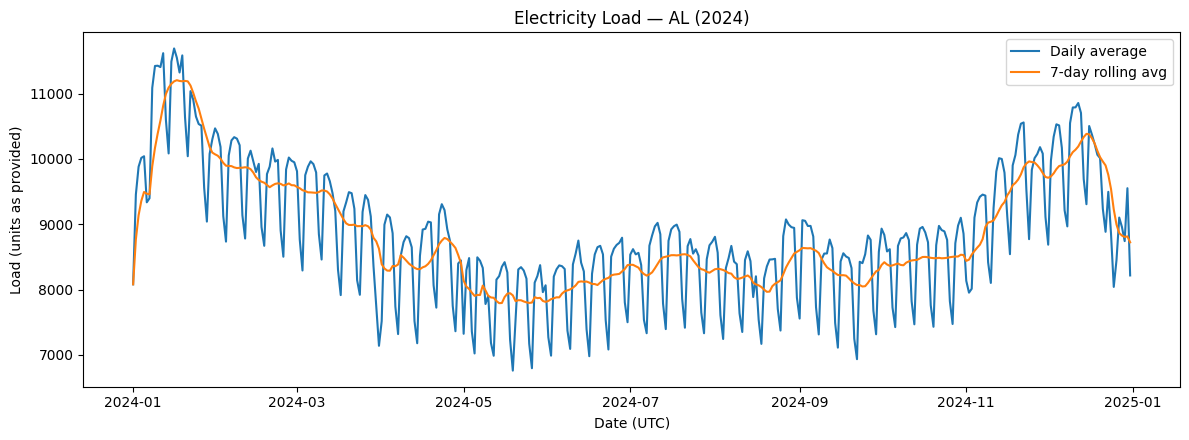

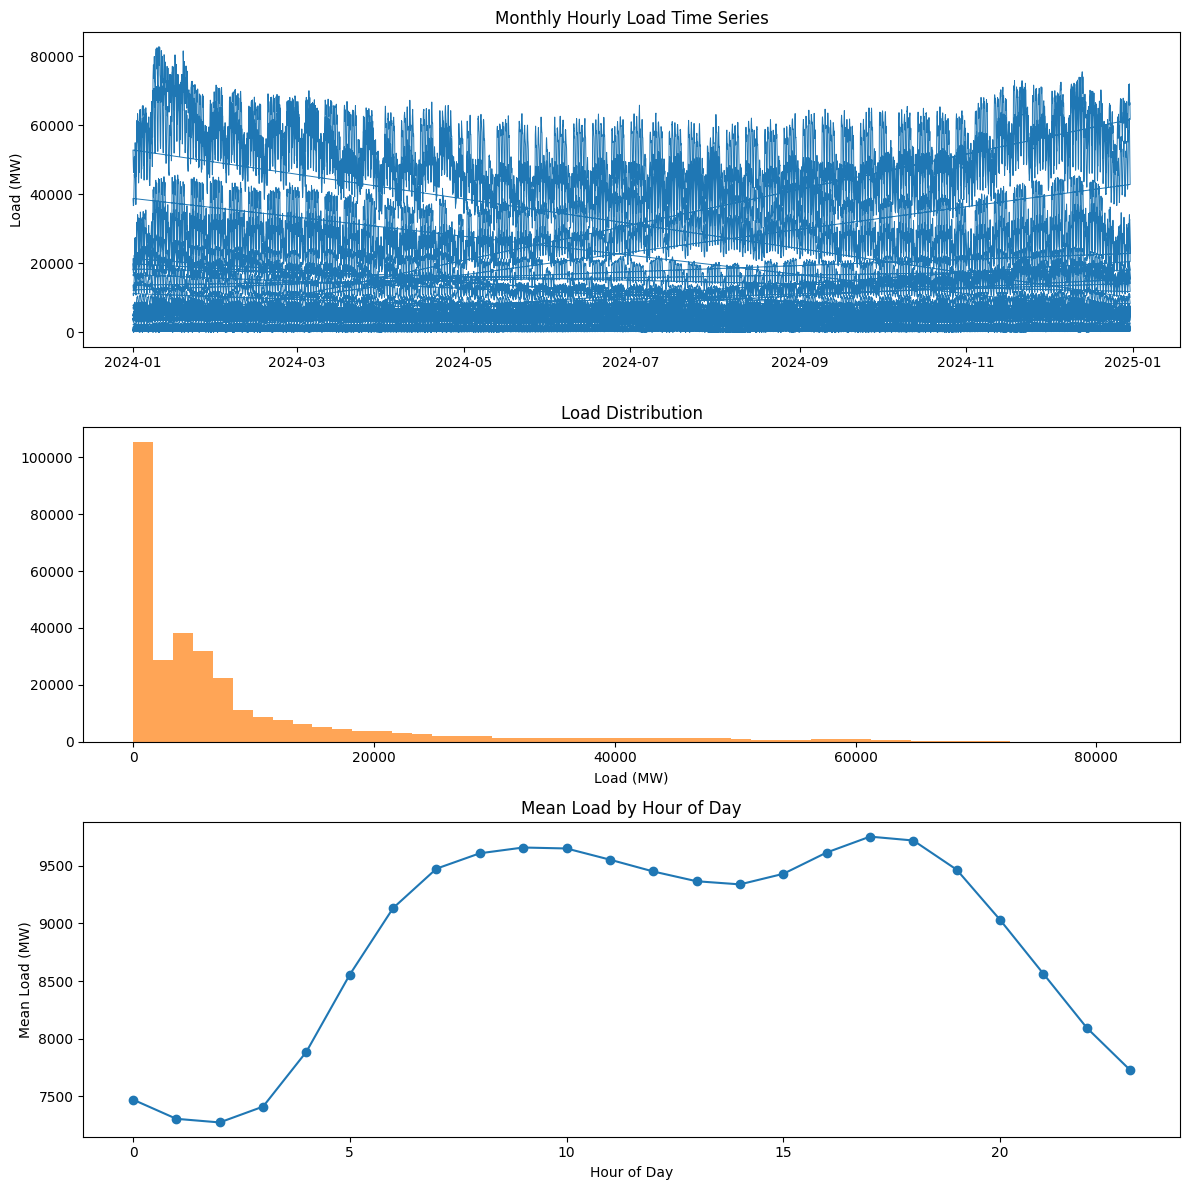

In [38]:
analyze_monthly_hourly_load(
    "data/monthly_hourly_load_values_2024.csv", 
    start_date="2024-01-01", 
    end_date="2024-12-31"
    )

### Water Apport

The hydraulic power is the most important in Switzerland representing nearly 60% of the generated power. We must divide into 3 subcategories which are: 
- RoR (run of river): water that flows in a river and is not controlable, we can merely choose to turbinate. Famous example is the Rhône.  
- Storage (using a dam): water can be stored in the sense that we can choose the tiiming of it's conversion from potential energy to electric energy. Total possible volume would be $3.5\,\mathrm{km^3}$
- Turbinable (pumping water upwards) : water can be pumped up and stored which allows to discharge the grid and charge the water with potential energy.

Each of these sources present different challenges and opportunities. We will treat 2 datasets (RoR and Storage) to provide an idea of the magnitude of such consumptions. Finally we will treat the Turbinable as merely a flexible option. 


(source: 
- https://www.bfe.admin.ch/bfe/en/home/supply/renewable-energy/hydropower.html/#:~:text=Thanks%20to%20its%20topography%20and,in%20pumped%20storage%20power%20plants.)

#### 1 - RoR study 

RoR is considered all energy that is gained from runing water without human control. 

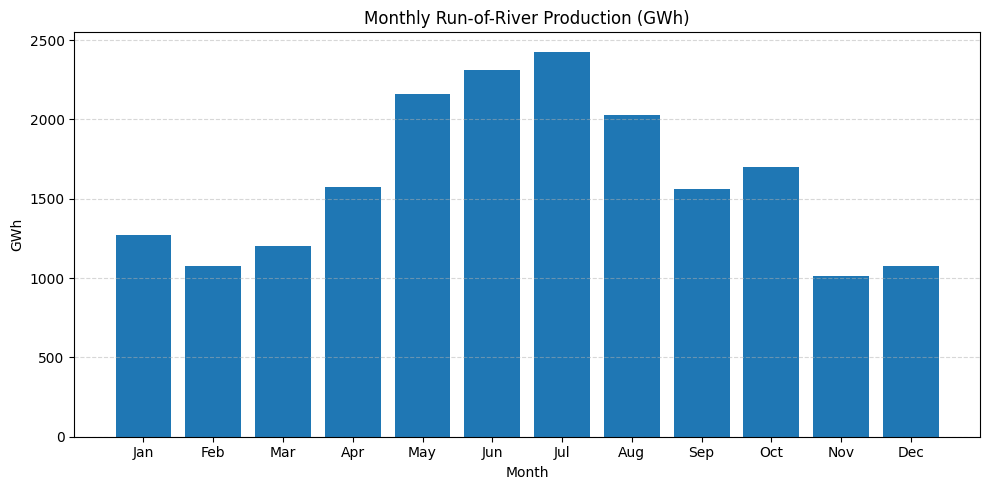

In [39]:
visualize_ror_monthly(
    "data/water_monthly_ror_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31"
)

#### 2 - Water storage

Water is controlled by a dam or a vavle to prevent it from freely exiting the natural sotrage solution. 

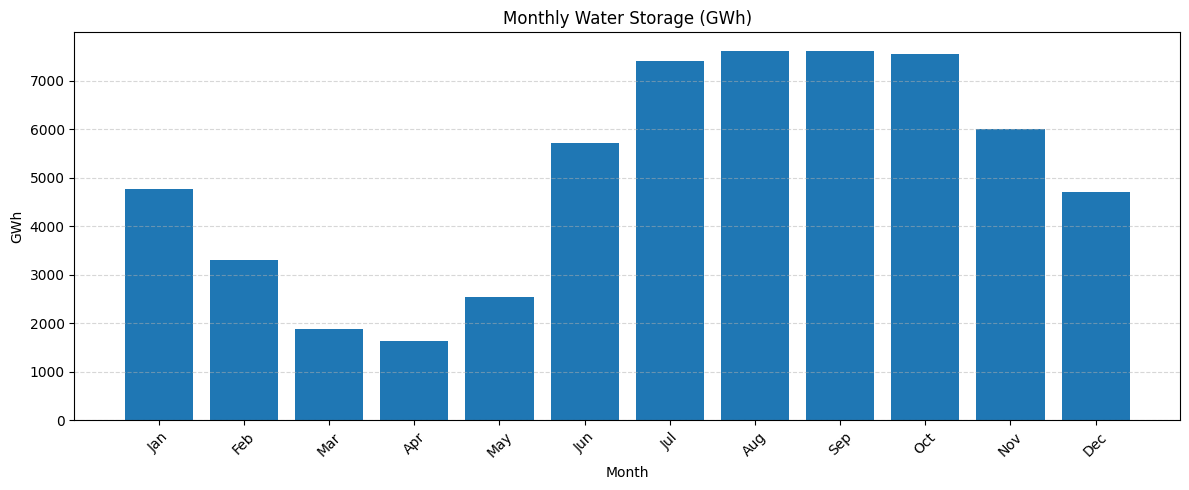

In [40]:
visualize_storage_monthly(
    "data/water_monthly_reservoir_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31"
)

## Part 2 - Modify Prof Züttel data into a manageable format  

Import of the Cost table from excel into a fully functioning csv already done. 

In [45]:
# I need to do the groups: 
### 1 - Production (go from natural ressource to electricity): 
HYD_S = ["Lake", "Hydro Turb", "Electricity", "Grid"]
HYD_R = ["River", "Hydro Turb", "Electricity", "Grid"]
THERM = ["Fuel Tank", "Fuel Transport", "Pipeline", "Ship transport", "Combined cycle power plant", "Electricity", "Grid"]
THERM_EX = ["Fuel Tank", "ICE"]
THERM_D = ["Fuel Tank", "Combined cycle power plant", "Electricity", "Grid"]
PV = ["PV", "Inverter DC/AC", "Battery", "Converter AC/DC", "Electricity", "Grid"]
WD_ON = ["Wind (onshore)", "Inverter DC/AC", "Battery", "Converter AC/DC", "Electricity", "Grid"]
THERM_G = ["Biogas","Combined cycle power plant",  "Electricity", "Grid"]
THERM_M = ["Biomass","Combined cycle power plant",  "Electricity", "Grid"]
H2P_G = ["H2 Storage UG 200bar","Hydrogen Transport","Combined cycle power plant", "Electricity", "Grid"]
H2P_L = ["Liquid storage","Hydrogen Transport","Combined cycle power plant", "Electricity", "Grid"]
SOL_SALT = ["Solar concentrator salt", "Steam generator", "Combined cycle power plant", "Electricity", "Grid"]
SOL_STEAM = ["Solar concentrator steam", "Combined cycle power plant", "Electricity", "Grid"]
BIO_OIL_ICE = ["Biooil", "Refining", "Fuel Tank", "ICE", "Electricity", "Grid"]
PALM_ICE = ["Palm oil", "Pyrolysis", "Biooil", "Cracking", "Refining", "ICE"]
BIO_WOOD = ["Wood", "Pyrolysis", "Biooil", "Steam reforming", "Combined cycle power plant", "Electricity", "Grid"]
WD_OFF = ["Wind (offshore)", "Inverter DC/AC", "Battery", "Converter AC/DC", "Electricity", "Grid"]
IMP_BIOG = ["Biogas (50% CH4)", "Pipeline", "Biogas purification", "Combined cycle power plant", "Electricity", "Grid"]
NH3_P = ["Ammonia cracking", "H2 Storage UG 200bar", "Hydrogen Transport", "Combined cycle power plant", "Electricity", "Grid"]


### 2 - Storage (Go from electricty to storage):
HY_LE = ["Hydro pump", "Lake"]
H2_G = ["Electrolyzer", "Compressor 30-200bar", "H2 Storage UG 200bar"]
H2_GL =["Electrolyzer", "Liquifaction", "Ship transport", "Liquid storage", "Liquid to gas", "Compressor 30-200bar", "H2 Storage UG 200bar"]
H2_L =["Electrolyzer", "Liquifaction", "Liquid storage"]
SYN_FT = ["Electrolyzer", "CO2 Capture 400 ppm", "H2, CO2 compression", "FT-Synthesis", "Refining", "Fuel Tank"]
SYN_METH = ["Electrolyzer", "CO2 Capture 400 ppm", "Sabatier reaction", "Methane compression", "CH4 storage 200bar"]
NH3_FULL = ["Electrolyzer", "N2 separation", "N2,H2 compression", "NH3 synthesis", "Ammonia liquifaction", "Ammonia storage"]
SYN_CRACK = ["Electrolyzer", "Palm oil", "H2, CO2 compression", "Cracking", "Refining", "Fuel Tank"]
CH4_BIO = ["Electrolyzer", "Biogas purification", "Sabatier reaction", "Methane compression", "Biogas (50% CH4)"]

# Save the ppu_data table (PPU and list of components) to a CSV
import pandas as pd

ppu_data = [
    {"PPU": "HYD_S", "Components": HYD_S, "Category": "Production"},
    {"PPU": "HYD_R", "Components": HYD_R, "Category": "Production"},
    {"PPU": "THERM", "Components": THERM, "Category": "Production"},
    {"PPU": "PV", "Components": PV, "Category": "Production"},
    {"PPU": "WD_ON", "Components": WD_ON, "Category": "Production"},
    {"PPU": "WD_OFF", "Components": WD_OFF, "Category": "Production"},
    {"PPU": "THERM_G", "Components": THERM_G, "Category": "Production"},
    {"PPU": "THERM_M", "Components": THERM_M, "Category": "Production"},
    {"PPU": "H2P_G", "Components": H2P_G, "Category": "Production"},
    {"PPU": "H2P_L", "Components": H2P_L, "Category": "Production"},
    {"PPU": "SOL_SALT", "Components": SOL_SALT, "Category": "Production"},
    {"PPU": "SOL_STEAM", "Components": SOL_STEAM, "Category": "Production"},
    {"PPU": "BIO_OIL_ICE", "Components": BIO_OIL_ICE, "Category": "Production"},
    {"PPU": "PALM_ICE", "Components": PALM_ICE, "Category": "Production"},
    {"PPU": "BIO_WOOD", "Components": BIO_WOOD, "Category": "Production"},
    {"PPU": "WD_OFF", "Components": WD_OFF, "Category": "Production"},
    {"PPU": "IMP_BIOG", "Components": IMP_BIOG, "Category": "Production"},
    {"PPU": "NH3_P", "Components": NH3_P, "Category": "Production"},
    {"PPU": "H2_G", "Components": H2_G, "Category": "Storage"},
    {"PPU": "H2_GL", "Components": H2_GL, "Category": "Storage"},
    {"PPU": "H2_L", "Components": H2_L, "Category": "Storage"},
    {"PPU": "SYN_FT", "Components": SYN_FT, "Category": "Storage"},
    {"PPU": "SYN_METH", "Components": SYN_METH, "Category": "Storage"},
    {"PPU": "NH3_FULL", "Components": NH3_FULL, "Category": "Storage"},
    {"PPU": "SYN_CRACK", "Components": SYN_CRACK, "Category": "Storage"},
    {"PPU": "CH4_BIO", "Components": CH4_BIO, "Category": "Storage"},
]

ppu_df = pd.DataFrame(ppu_data)
ppu_df["Components"] = ppu_df["Components"].apply(str)
ppu_df.to_csv("data/ppu_constructs_components.csv", index=False)
display(ppu_df)
print("Saved PPU constructs and their components to data/ppu_constructs_components.csv")

,PPU,Components,Category
0,HYD_S,"['Lake', 'Hydro Turb', 'Electricity', 'Grid']",Production
1,HYD_R,"['River', 'Hydro Turb', 'Electricity', 'Grid']",Production
2,THERM,"['Fuel Tank', 'Fuel Transport', 'Pipeline', 'S...",Production
3,PV,"['PV', 'Inverter DC/AC', 'Battery', 'Converter...",Production
4,WD_ON,"['Wind (onshore)', 'Inverter DC/AC', 'Battery'...",Production
5,WD_OFF,"['Wind (offshore)', 'Inverter DC/AC', 'Battery...",Production
6,THERM_G,"['Biogas', 'Combined cycle power plant', 'Elec...",Production
7,THERM_M,"['Biomass', 'Combined cycle power plant', 'Ele...",Production
8,H2P_G,"['H2 Storage UG 200bar', 'Hydrogen Transport',...",Production
9,H2P_L,"['Liquid storage', 'Hydrogen Transport', 'Comb...",Production


Saved PPU constructs and their components to data/ppu_constructs_components.csv


In [ ]:
import pandas as pd

rows = [
    # Demand & growth
    ("demand_base_twh_per_year", "demand", 62, "TWh/year", "", "", "Swiss electricity demand in 2019"),
    ("demand_target_twh_per_year", "demand", 113, "TWh/year", "", "", "Electrified demand incl. nuclear replacement (2050)"),
    ("demand_additional_twh_per_year", "demand", 74, "TWh/year", "", "", "Increment vs. 2019 needed from renewables"),
    ("demand_electrification_addition_twh_per_year", "demand", 53, "TWh/year", "", "", "Added demand from electrification of uses"),
    ("demand_nuclear_replacement_twh_per_year", "demand", 21, "TWh/year", "", "", "Added demand to replace nuclear output"),
    ("buildout_cadence_twh_per_year", "deployment", 2.4, "TWh/year", "", "", "Average annual new production to 2050"),
    # Storage sizing rules (system-level)
    ("day_night_storage_share_of_annual", "storage_rules", 0.0025, "fraction of annual demand", 0.0025, 0.0025, "Rule of thumb: 0.25% of annual electricity demand"),
    ("seasonal_storage_share_of_annual", "storage_rules", 0.25, "fraction of annual demand", 0.25, 0.25, "Rule of thumb: 25% of annual electricity demand"),
    ("seasonal_storage_absolute_twh", "storage_rules", 20, "TWh", "", "", "Seasonal storage energy target for winter shift"),
    ("seasonal_intake_power_required_gw", "storage_rules", 20, "GW", "", "", "Summer absorption power to fill seasonal storage"),
    ("pv_peak_power_expected_gw", "supply_profile", 90, "GW", "", "", "Expected PV noon peak for +50 TWh/y PV"),
    ("battery_power_cap_target_gw", "supply_profile", 32, "GW", "", "", "Target capped grid peak after local batteries"),
    # PPU definition
    ("ppu_output_electricity_twh_per_year", "ppu", 8.76, "TWh/year", "", "", "Energy delivered per PPU (on demand)"),
    # Redundancy & policy levers
    ("ppu_required_count_core", "planning", 6, "count", "", "", "PPUs to supply missing band electricity (53 TWh/y)"),
    ("ppu_required_count_redundancy", "planning", 2, "count", "", "", "Additional PPUs for redundancy (≈33%)"),
    ("dam_height_increase_pct", "planning", 26, "%", "", "", "Dam raise to double lake storage capacity"),
    ("storage_shift_from_summer_to_winter_twh", "planning", 9, "TWh/year", "", "", "Shift enabled by higher dams"),
    ("biomass_for_heating_current_twh_per_year", "planning", 15, "TWh/year", "", "", "Current biomass allocated to heating"),
    ("biomass_for_heating_additional_twh_per_year", "planning", 5, "TWh/year", "", "", "Additional biomass to heating"),
    ("rooftop_pv_potential_twh_per_year", "planning", 24, "TWh/year", "", "", "All feasible roof areas covered with PV"),
    # Economics & finance
    ("grid_cost_adder_chf_per_kwh", "costing", 0.09, "CHF/kWh", "", "", "Adder to production cost for grid"),
    ("finance_interest_rate_per_year", "costing", 0.02, "1/year", "", "", "Interest rate Z in annuity formula"),
    # Future component cost/efficiency assumptions
    ("pv_future_capex_chf_per_kwp", "future_costs", 200, "CHF/kWp", "", "", "Assumed future PV CAPEX"),
    ("battery_future_capex_chf_per_kwh", "future_costs", 55, "CHF/kWh", "", "", "Assumed future battery CAPEX"),
    ("electrolyser_future_capex_chf_per_kw", "future_costs", 500, "CHF/kW", "", "", "Assumed future electrolyser CAPEX"),
    ("electrolyser_future_efficiency", "future_costs", 0.90, "fraction", "", "", "Assumed future electrolyser efficiency"),
    ("power_electronics_future_capex_chf_per_kw", "future_costs", 200, "CHF/kW", "", "", "Converters/inverters assumed future CAPEX"),
    ("dac_future_cost_chf_per_ton_co2", "future_costs", 200, "CHF/tCO2", "", "", "Assumed future DAC cost"),
    ("h2_liquefaction_future_cost_chf_per_kg", "future_costs", 2000, "CHF/kg", "", "", "Assumed future LH2 liquefaction cost"),
    ("h2_future_cost_chf_per_kg_default", "future_costs", 6.0, "CHF/kg", 5.0, 7.0, "Implied future H2 cost (range 5–7)"),
    ("syn_oil_future_cost_chf_per_kg_default", "future_costs", 2.5, "CHF/kg", 2.3, 2.7, "Implied future synthetic oil cost (range)"),
    # PPU technology inputs (areas, storage)
    ("pv_hyd_pv_active_area_km2_per_ppu", "ppu_params", 51, "km^2", "", "", "Active PV area per PV-HYD PPU"),
    ("pv_h2_pv_active_area_km2_per_ppu", "ppu_params", 83, "km^2", "", "", "Active PV area per PV-H2 PPU"),
    ("bio_sf_pv_active_area_km2_per_ppu", "ppu_params", 89, "km^2", "", "", "Active PV area per Bio-SF PPU"),
    ("imp_sf_pv_active_area_km2_per_ppu", "ppu_params", 62, "km^2", "", "", "Active PV area per Imp-SF PPU (abroad)"),
    ("imp_psf_pv_active_area_km2_per_ppu", "ppu_params", 5.6, "km^2", "", "", "Active PV area per Imp-PSF PPU (abroad)"),
    ("imp_h2_pv_active_area_km2_per_ppu", "ppu_params", 113, "km^2", "", "", "Active PV area per Imp-H2 PPU (abroad)"),
    ("bio_sf_biomass_mass_mt_per_year", "ppu_params", 1.5, "Mt/year", "", "", "Dry biomass input per Bio-SF PPU"),
    ("bio_sf_plantation_area_km2", "ppu_params", 7500, "km^2", "", "", "Local plantation area for Bio-SF PPU"),
    ("imp_psf_plantation_area_km2", "ppu_params", 2350, "km^2", "", "", "Plantation area for Imp-PSF PPU"),
    ("imp_sf_dac_co2_mt_per_year", "ppu_params", 2.3, "Mt/year", "", "", "CO2 captured per Imp-SF PPU via DAC"),
    ("imp_h2_h2_cost_today_chf_per_kg", "ppu_params", 19.4, "CHF/kg", "", "", "Reference current cost of imported H2"),
    ("imp_h2_annual_h2_mass_for_1gw_tonnes", "ppu_params", 448000, "t/year", "", "", "H2 consumption for 1 GW CCPP continuous"),
    ("h2_reserve_storage_mass_tonnes", "ppu_params", 112000, "t", "", "", "Reserve LH2 storage mass (≈3 months)"),
    ("h2_liquid_vs_200bar_volume_ratio", "ppu_params", 4, "dimensionless", "", "", "Liquid storage is 4× more compact than 200 bar"),
    ("pv_field_to_active_area_factor", "ppu_params", 2.25, "ratio", 2.0, 2.5, "Field area ≈2–2.5× active PV area"),
    # Storage media densities & civil works
    ("hydrolake_storage_density_kwh_per_m3_mid", "storage_phys", 2.5, "kWh/m^3", 1.0, 4.0, "Electricity storage density for 500–1800 m head"),
    ("excavation_energy_kwh_per_m3", "storage_phys", 30, "kWh/m^3", "", "", "Energy to excavate valley (order of magnitude)"),
    # LCOE per PPU (ex-grid; add grid cost separately)
    ("lcoe_nuc_chf_per_kwh_ex_grid", "lcoe", 0.08, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_pv_hyd_chf_per_kwh_ex_grid", "lcoe", 0.24, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_pv_h2_chf_per_kwh_ex_grid", "lcoe", 0.44, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_bio_sf_to_power_chf_per_kwh_ex_grid", "lcoe", 0.47, "CHF/kWh", "", "", "Electricity LCOE if synthetic fuel used for power"),
    ("lcoe_imp_h2_chf_per_kwh_ex_grid", "lcoe", 1.02, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_imp_sf_to_power_chf_per_kwh_ex_grid", "lcoe", 2.20, "CHF/kWh", "", "", "Electricity LCOE if synfuel (PV+DAC) used for power"),
    ("lcoe_imp_psf_to_power_chf_per_kwh_ex_grid", "lcoe", 0.35, "CHF/kWh", "", "", "Electricity LCOE if palm synfuel used for power"),
    # CAPEX (order-of-magnitude, for constraints/sensitivity)
    ("capex_nuc_bchf", "capex", 10, "BCHF", 8, 12, "Initial CAPEX range"),
    ("capex_pv_hyd_bchf", "capex", 32, "BCHF", "", "", "Initial CAPEX"),
    ("capex_pv_h2_bchf", "capex", 84, "BCHF", "", "", "Initial CAPEX"),
    ("capex_bio_sf_bchf", "capex", 60, "BCHF", "", "", "Initial CAPEX"),
    ("capex_imp_h2_bchf_local", "capex", 7, "BCHF", "", "", "Local CAPEX (excl. abroad infra)"),
    ("capex_imp_h2_bchf_abroad", "capex", 106, "BCHF", "", "", "Abroad CAPEX"),
    ("capex_imp_sf_bchf_local", "capex", 5, "BCHF", "", "", "Local CAPEX"),
    ("capex_imp_sf_bchf_abroad", "capex", 57, "BCHF", "", "", "Abroad CAPEX"),
    ("capex_imp_psf_bchf_local", "capex", 4, "BCHF", "", "", "Local CAPEX"),
    ("capex_imp_psf_bchf_abroad", "capex", 10, "BCHF", "", "", "Abroad CAPEX"),
]

df = pd.DataFrame(rows, columns=["key", "category", "default_value", "unit", "lower_bound", "upper_bound", "notes"])

# Save to CSV
csv_path = "data/optimization_inputs_from_paper.csv"
df.to_csv(csv_path, index=False)

df.head()


,key,category,default_value,unit,lower_bound,upper_bound,notes
0,demand_base_twh_per_year,demand,62.0,TWh/year,,,Swiss electricity demand in 2019
1,demand_target_twh_per_year,demand,113.0,TWh/year,,,Electrified demand incl. nuclear replacement (...
2,demand_additional_twh_per_year,demand,74.0,TWh/year,,,Increment vs. 2019 needed from renewables
3,demand_electrification_addition_twh_per_year,demand,53.0,TWh/year,,,Added demand from electrification of uses
4,demand_nuclear_replacement_twh_per_year,demand,21.0,TWh/year,,,Added demand to replace nuclear output


## Portfolio Optimization Display: Efficiency Frontier

The efficiency frontier represents the set of optimal portfolios that offer the highest expected return for a given level of risk (volatility), or equivalently, the lowest risk for a given expected return. In the context of Power Production Unit (PPU) optimization, this frontier illustrates the trade-off between maximizing the yearly arithmetic mean return (average of 15-minute discrete returns, $\mathrm{Return}_t = \frac{1}{\mathrm{cost}_t + \varepsilon}$) and minimizing the yearly average price volatility (standard deviation of returns, proxy for cost variability). Portfolios below the frontier are suboptimal, as they provide lower returns for the same risk or higher risk for the same return. The optimal PPU mix lies on this frontier, balancing cost stability with high returns to achieve sovereign, CO2-neutral energy. We simulate multiple portfolio scenarios by varying cost parameters to construct and display this frontier.

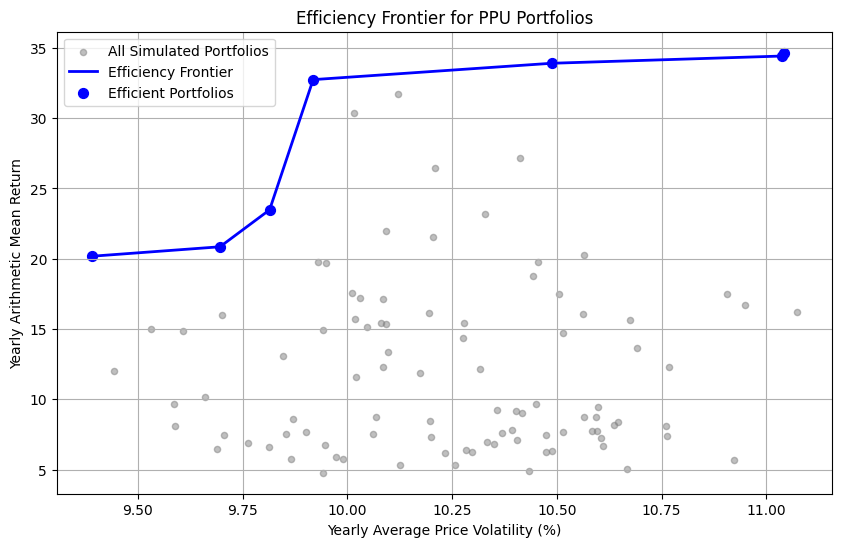

Optimal Portfolio - Volatility: 11.04%, Return: 34.6548


In [1]:
# --- Efficiency Frontier Display ---
# This code simulates multiple PPU portfolios by varying cost parameters,
# computes their yearly mean return and volatility, and plots the efficiency frontier.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Parameters
np.random.seed(42)
n_timesteps = 96 * 365  # 15-min timesteps in a year
epsilon = 1e-6
n_portfolios = 100  # Number of simulated portfolios

# Simulate multiple portfolios by varying cost scale (lower scale = lower costs = higher returns)
scales = np.random.uniform(0.5, 2.0, n_portfolios)  # Cost scales

portfolios = []
for scale in scales:
    costs = np.random.exponential(scale, n_timesteps)
    returns = 1 / (costs + epsilon)
    # Aggregate to daily
    daily_returns = pd.Series(returns).groupby(np.arange(len(returns)) // 96).mean()
    daily_costs = pd.Series(costs).groupby(np.arange(len(costs)) // 96).mean()
    mean_return = daily_returns.mean()
    # Volatility as coefficient of variation of daily costs, in %
    volatility = (daily_costs.std() / daily_costs.mean()) * 100
    portfolios.append((volatility, mean_return))

# Convert to array
portfolios = np.array(portfolios)

# Find the efficiency frontier: portfolios with maximum return for each volatility
sorted_idx = np.argsort(portfolios[:, 0])  # Sort by volatility
efficient = []
for i in sorted_idx:
    if not efficient or portfolios[i, 1] > efficient[-1][1]:
        efficient.append(portfolios[i])

efficient = np.array(efficient)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(portfolios[:, 0], portfolios[:, 1], s=20, alpha=0.5, color='gray', label="All Simulated Portfolios")
ax.plot(efficient[:, 0], efficient[:, 1], 'b-', linewidth=2, label="Efficiency Frontier")
ax.scatter(efficient[:, 0], efficient[:, 1], s=50, color='blue', label="Efficient Portfolios")
ax.set_xlabel('Yearly Average Price Volatility (%)')
ax.set_ylabel('Yearly Arithmetic Mean Return')
ax.set_title('Efficiency Frontier for PPU Portfolios')
ax.legend(loc="best")
ax.grid(True)
plt.show()

# Print the optimal portfolio (highest return on frontier)
optimal_idx = np.argmax(efficient[:, 1])
print(f"Optimal Portfolio - Volatility: {efficient[optimal_idx, 0]:.2f}%, Return: {efficient[optimal_idx, 1]:.4f}")